# Large Movie Deconvolution
This notebook is the beginning of some experiments in deconvoluting a large movie (namely, the sample provided by Shay). The main challenge presented here is that you aren't able to load the entire movie into memory, process it frame by frame to generate another huge ndarray in memory, and then dump that second huge ndarray into a `.tif` file. Instead, you want to loop over all frames, load one frame at a time, process that one frame, and then dump the processed frame directly into the output file. That output file should be a "raw" 2 byte-per-pixel movie, essentially the same as an `.isxd` file but without the json metadata at the end.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../common/")
import isxd_reader
import denoising

In [2]:
# this is the standard movie of the striatum, spatially bandpassed
standard_movie_path = "../data/recording_20180402_094031-PP-bp-mc.isxd"

# some additional information about this movie
# the dimensions of the movie
dimensions = (526,636)
# the amount of metadata between frames (there is none)
metadata_size=(0,0)

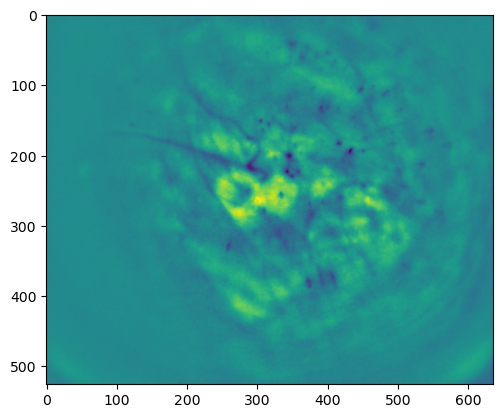

In [3]:
frame_100 = isxd_reader.load_image2(standard_movie_path, index=1000, dimensions=dimensions, metadata_size=metadata_size)
plt.imshow(frame_100)

Below: getting the number of frames by subtracting the size of the metadata from the size of the file, and then dividing the size of the file by the size of a frame

In [4]:
file_size = os.path.getsize(standard_movie_path)
with open(standard_movie_path, 'rb') as file:
    # get metadata size
    file.seek(-8, 2)
    metadata_json_size = int.from_bytes(file.read(8), byteorder='little')
    data_size = file_size - metadata_json_size - 9 # metadata is followed by an extra '\0' byte and then 8 bytes of size count
    num_frames = data_size//int(2*dimensions[0]*dimensions[1] + metadata_size[0] + metadata_size[1])
    file.seek(0)

In [5]:
metadata_json_size

1115

In [6]:
num_frames

35992

I want to process the entire movie. For that, I want to load the whole thing frame-by-frame, process each frame, and write it out to a file.

In [7]:
# create the output file if it does not exist, truncate (override) whatever already exists
outfile = open('../data/outmovie.raw', 'w+b')

In [8]:
# practice writing a frame to the file
outfile.write(frame_100.tobytes())

669072

In [9]:
outfile.close()

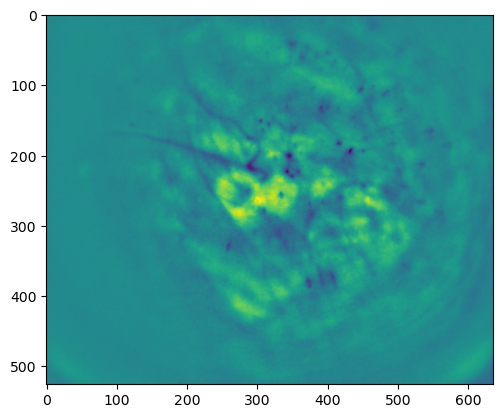

In [10]:
plt.imshow(isxd_reader.load_image2('../data/outmovie.raw', index=0, dimensions=dimensions, metadata_size=metadata_size))

**SICK!!!** That actually worked!! The next step is loading the neural network so that we can process the movie, and then actually processing it frame by frame.

In [11]:
import preset_nn

# the model that you create has to match the saved weights
# the default created by instant_multiwienernet is the same as noisy5.
# However, you may want to use e.g. blurpools as per Zhang, 2019.
# In that case, you may want to use something like the commented-out line:
# model = preset_nn.instant_multiwienernet(pooling='averageblur')
model = preset_nn.instant_multiwienernet()

# replace this with the path to the model weights that you save
weights_path = "saved_models/multiwiener_nV3_probe_noisy5/model_weights"

model.load_weights(weights_path)

2023-04-28 09:13:38.594090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 09:13:38.782218: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 09:13:38.818100: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-28 09:13:40.553768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [33]:
with open('../data/outmovie.raw', 'w+b') as outfile:
    for frame in range(100):
        print("frame: " + str(frame))
        outfile.seek(2*800*1280*frame)
        in_img = isxd_reader.load_image2(standard_movie_path, index=frame, dimensions=dimensions, metadata_size=metadata_size)
        in_img_padded = np.pad(in_img, ((137,137), (322,322)))
        in_img_scaled = denoising.rescale_to_one(in_img_padded)
        out_img = model(in_img_scaled.reshape((1,800,1280,1)))[0,:,:].numpy()
        out_img_2B = (denoising.rescale_to_one(out_img)*65535).astype(np.uint16)
        outfile.write(out_img_2B)

frame: 0
frame: 1
frame: 2
frame: 3
frame: 4
frame: 5
frame: 6
frame: 7
frame: 8
frame: 9
frame: 10
frame: 11
frame: 12
frame: 13
frame: 14
frame: 15
frame: 16
frame: 17
frame: 18
frame: 19
frame: 20
frame: 21
frame: 22
frame: 23
frame: 24
frame: 25
frame: 26
frame: 27
frame: 28
frame: 29
frame: 30
frame: 31
frame: 32
frame: 33
frame: 34
frame: 35
frame: 36
frame: 37
frame: 38
frame: 39
frame: 40
frame: 41
frame: 42
frame: 43
frame: 44
frame: 45
frame: 46
frame: 47
frame: 48
frame: 49
frame: 50
frame: 51
frame: 52
frame: 53
frame: 54
frame: 55
frame: 56
frame: 57
frame: 58
frame: 59
frame: 60
frame: 61
frame: 62
frame: 63
frame: 64
frame: 65
frame: 66
frame: 67
frame: 68
frame: 69
frame: 70
frame: 71
frame: 72
frame: 73
frame: 74
frame: 75
frame: 76
frame: 77
frame: 78
frame: 79
frame: 80
frame: 81
frame: 82
frame: 83
frame: 84
frame: 85
frame: 86
frame: 87
frame: 88
frame: 89
frame: 90
frame: 91
frame: 92
frame: 93
frame: 94
frame: 95
frame: 96
frame: 97
frame: 98
frame: 99


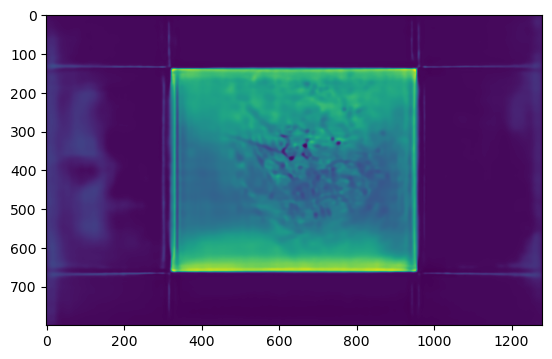

In [32]:
plt.imshow(isxd_reader.load_image2('../data/outmovie.raw', index=0, metadata_size=metadata_size, dimensions=(800,1280)))

In [24]:
in_img = isxd_reader.load_image2(standard_movie_path, index=0, dimensions=dimensions, metadata_size=metadata_size)
in_img_padded = np.pad(in_img, ((137,137), (322,322)))
in_img_scaled = denoising.rescale_to_one(in_img_padded)
out_img = model(in_img_scaled.reshape((1,800,1280,1)))[0,:,:].numpy()
out_img_2B = (denoising.rescale_to_one(out_img)*65535).astype(np.uint16)

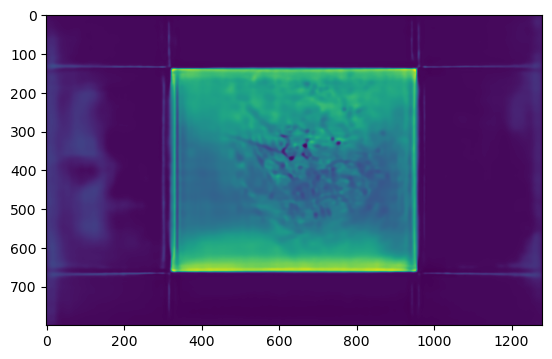

In [25]:
plt.imshow(out_img_2B)